In [ ]:
import torch
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = os.path.join('/content/drive', 'My Drive', 'UCR', '2-2024', 'InvCC', 'ADHD200', 'Datasets', 'preprocessed')

import os

root_dir = os.path.join('preprocessed')

# Carpetas para TDC y ADHD
tdc_dir = os.path.join(root_dir, 'TDC')
adhd_dir = os.path.join(root_dir, 'ADHD')

# Para guardar el estado del autoencoder
save_path = os.path.join(root_dir, 'autoencoder_0.pt')

# Listas para almacenar las rutas de archivos
tdc_file_paths = [os.path.join(tdc_dir, file) for file in os.listdir(tdc_dir) if file.endswith('.nii.gz')]
adhd_file_paths = [os.path.join(adhd_dir, file) for file in os.listdir(adhd_dir) if file.endswith('.nii.gz')]

# Etiquetas correspondientes
tdc_labels = [0] * len(tdc_file_paths)
adhd_labels = [1] * len(adhd_file_paths)

# Combinar rutas de archivos y etiquetas
file_paths = tdc_file_paths + adhd_file_paths
labels = tdc_labels + adhd_labels

In [ ]:
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
from scipy.ndimage import zoom

# Target voxel dimensions and time dimension
TARGET_VOXEL_DIM = (4.0, 4.0, 4.0)  # Adjust as needed
TARGET_TIME_DIM = 100  # Adjust as needed

class FMRI_Dataset(Dataset):
    def __init__(self, file_paths, labels, max_shape, smoothing_sigma=1, augment=False):
        self.file_paths = file_paths  # List of paths to the fMRI data files
        self.labels = labels  # Corresponding labels
        self.max_shape = max_shape  # Shape to pad all inputs to
        self.smoothing_sigma = smoothing_sigma  # Standard deviation for Gaussian smoothing
        self.augment = augment  # Apply augmentations if True

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load fMRI data on-the-fly
        data = self.load_and_preprocess(self.file_paths[idx])

        # Normalize the data and convert to tensor with reduced precision
        data_tensor = torch.tensor(data, dtype=torch.float16).unsqueeze(0)  # Use float16 for memory efficiency

        # Pad the tensor to the specified max_shape
        data_padded = self.pad_tensor(data_tensor)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return data_padded, label

    def load_and_preprocess(self, file_path):
        # Use memory mapping to load data
        img = nib.load(file_path)
        data = img.get_fdata(dtype=np.float32)  # Load as float32 to prevent overflow

        # Handle dimensionality
        if data.ndim == 5:
            data = np.mean(data, axis=-1)  # Average to reduce dimensionality
        elif data.ndim == 3:
            data = np.expand_dims(data, axis=-1)  # Ensure at least 4D

        # Resampling to target voxel size
        current_voxel_dim = img.header.get_zooms()[:3]
        scale_factors = [t / c for t, c in zip(TARGET_VOXEL_DIM, current_voxel_dim)]
        data = zoom(data, scale_factors + [1], order=1)  # Keep the time dimension intact

        # Adjust time dimension
        data = self.adjust_time_dimension(data)

        return self.normalize_data(data)

    def adjust_time_dimension(self, data):
        if data.shape[-1] > TARGET_TIME_DIM:
            data = data[..., :TARGET_TIME_DIM]  # Truncate
        elif data.shape[-1] < TARGET_TIME_DIM:
            pad_width = TARGET_TIME_DIM - data.shape[-1]
            if pad_width > 0:
                pad_width_tuple = ((0, 0), (0, 0), (0, 0), (0, pad_width))
                data = np.pad(data, pad_width_tuple, mode='constant')
        return data

    def normalize_data(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / (std + 1e-8)  # Avoid division by zero

    def pad_tensor(self, tensor):
        # Calculate padding
        padding = [max_dim - current_dim for current_dim, max_dim in zip(tensor.shape, self.max_shape)]
        return F.pad(tensor, pad=padding, mode='constant', value=0)

In [ ]:
# Example usage
file_paths = ['path_to_func_data1.nii.gz', 'path_to_func_data2.nii.gz']  # Replace with actual paths
labels = [0, 1]  # Corresponding labels for your dataset
max_shape = (1, 53, 64, 46, 100)  # Example max shape

dataset = FMRI_Dataset(file_paths, labels, max_shape, smoothing_sigma=1)

# Example of creating a DataLoader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import torch

# Assuming `dataset` is your instantiated FMRI_Dataset class with labels.

# Create a StratifiedShuffleSplit object to split into training and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Ensure labels are on CPU for compatibility with sklearn
labels_cpu = dataset.labels.cpu().numpy() if isinstance(dataset.labels, torch.Tensor) else dataset.labels

# Split into training/validation and test sets
for train_val_idx, test_idx in sss.split(range(len(dataset)), labels_cpu):
    train_val_set = Subset(dataset, train_val_idx)
    testset = Subset(dataset, test_idx)

# Create another StratifiedShuffleSplit for training and validation sets
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 0.25 of 0.8 gives 0.2 total for validation

# Access labels for train_val_set
train_val_labels = [labels_cpu[i] for i in train_val_idx]  # Use list comprehension to retrieve labels

# Split train_val_set into train and validation sets
for train_idx, val_idx in sss_val.split(range(len(train_val_set)), train_val_labels):
    trainset = Subset(train_val_set, train_idx)
    valset = Subset(train_val_set, val_idx)

# Create dataloaders
batch_size = 4
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class_names = ["TDC", "ADHD"]

# Verify the dataloaders
# Print shapes of a sample batch from the training loader
for images, labels in trainloader:
    if images is not None:
        print(f"Train - Shape of inputs: {images.shape}, Shape of labels: {labels.shape}")
        break

# Print shapes of a sample batch from the test loader
for images, labels in testloader:
    if images is not None:
        print(f"Test - Shape of inputs: {images.shape}, Shape of labels: {labels.shape}")
        break

Label at index 1347: 1
Label at index 1536: 1
Label at index 83: 0
Label at index 1614: 1
Train - Shape of inputs: torch.Size([4, 1, 53, 64, 47, 512]), Shape of labels: torch.Size([4])
Label at index 214: 0
Label at index 1215: 1
Label at index 1662: 1
Label at index 852: 1
Test - Shape of inputs: torch.Size([4, 1, 53, 64, 47, 512]), Shape of labels: torch.Size([4])


In [ ]:
print(f"Number of samples in valloader: {len(valloader.dataset)}")
print(f"Number of samples in trainloader: {len(trainloader.dataset)}")
print(f"Number of samples in testloader: {len(testloader.dataset)}")

Number of samples in valloader: 335
Number of samples in trainloader: 1004
Number of samples in testloader: 335


In [ ]:
import nibabel as nib

# Loop through each file path
for i, file_path in enumerate(file_paths):
    # Load the fMRI data
    img = nib.load(file_path)
    data = img.get_fdata()
    
    # Print the data shape and voxel dimensions
    print(f"File {i+1}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Voxel dimensions: {img.header.get_zooms()}")
    print("-" * 30)


File 1:
  Data shape: (49, 58, 47, 10)
  Voxel dimensions: (4.0, 4.0, 4.0, 1.0)
------------------------------
File 2:
  Data shape: (53, 64, 46, 171)
  Voxel dimensions: (3.0, 3.0, 3.0, 2.0)
------------------------------
File 3:
  Data shape: (49, 58, 47)
  Voxel dimensions: (4.0, 4.0, 4.0)
------------------------------
File 4:
  Data shape: (49, 58, 47, 257)
  Voxel dimensions: (4.0, 4.0, 4.0, 1.96)
------------------------------
File 5:
  Data shape: (49, 58, 47)
  Voxel dimensions: (4.0, 4.0, 4.0)
------------------------------
File 6:
  Data shape: (49, 58, 47, 231)
  Voxel dimensions: (4.0, 4.0, 4.0, 1.0)
------------------------------
File 7:
  Data shape: (49, 58, 47)
  Voxel dimensions: (4.0, 4.0, 4.0)
------------------------------
File 8:
  Data shape: (49, 58, 47, 1, 10)
  Voxel dimensions: (4.0, 4.0, 4.0, 0.0, 0.0)
------------------------------
File 9:
  Data shape: (49, 58, 47, 231)
  Voxel dimensions: (4.0, 4.0, 4.0, 1.0)
------------------------------
File 10:
  Data

KeyboardInterrupt: 

Class distribution: Counter({tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1})


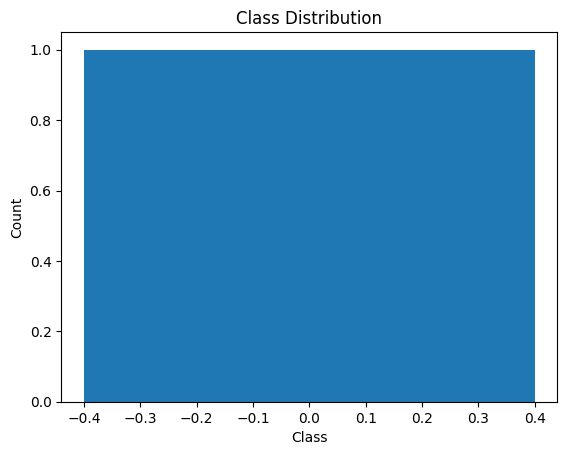

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count occurrences of each class label
class_counts = Counter(labels)
print("Class distribution:", class_counts)

# Visualize the distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


In [ ]:
print(dataset.labels)  # Inspect the label values to confirm they are correct


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import numpy as np

intensities = [np.mean(nib.load(fp).get_fdata()) for fp in file_paths]
plt.hist(intensities, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.title("Voxel Intensity Distribution")
plt.show()


KeyboardInterrupt: 

In [ ]:
# Assuming fMRI data is 4D [X, Y, Z, T] with T as the time dimension
time_series = sample_data.mean(axis=(0, 1, 2))  # Averaging across spatial dimensions

plt.plot(time_series)
plt.xlabel("Time (Volume Index)")
plt.ylabel("Mean Signal Intensity")
plt.title("Mean Signal Intensity Over Time")
plt.show()


In [ ]:
# Visualizing intensity distribution across a random slice
slice_idx = sample_data.shape[2] // 2  # Middle slice
plt.imshow(sample_data[:, :, slice_idx], cmap="gray")
plt.colorbar()
plt.title("Intensity Distribution on Middle Slice")
plt.show()


In [ ]:
mean_intensity = []
std_intensity = []
for fp in file_paths:
    data = nib.load(fp).get_fdata()
    mean_intensity.append(data.mean())
    std_intensity.append(data.std())

plt.subplot(1, 2, 1)
plt.hist(mean_intensity, bins=30, color="lightblue")
plt.xlabel("Mean Intensity")
plt.title("Mean Intensity Distribution")

plt.subplot(1, 2, 2)
plt.hist(std_intensity, bins=30, color="salmon")
plt.xlabel("Standard Deviation")
plt.title("Standard Deviation Distribution")
plt.show()


In [ ]:
# Calculate correlation between adjacent time points
corr_values = [np.corrcoef(sample_data[:, :, :, t].ravel(), sample_data[:, :, :, t+1].ravel())[0, 1] for t in range(sample_data.shape[3] - 1)]
plt.plot(corr_values)
plt.xlabel("Time Point")
plt.ylabel("Correlation with Next Frame")
plt.title("Temporal Correlation between Adjacent Frames")
plt.show()
